# 1. 패키지, 모듈, 클래스, 함수 불러오기

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np
import gc

# Visualization, EDA
import missingno as msno
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Korean font
#font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#rc('font', family=font_name)

# Preprocessing & Feature Engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import roc_auc_score

from keras.callbacks import ModelCheckpoint

# Utility
import re
import os
import time
import datetime
import random
import tensorflow as tf
import pickle
import joblib
import platform
import warnings; warnings.filterwarnings("ignore")
from itertools import combinations
from tqdm import tqdm, tqdm_notebook
from IPython.display import Image
from scipy.stats.mstats import gmean
from tensorflow import keras
from PIL import Image

In [2]:
# 코랩에서만 결로 설정
#from google.colab import drive
#drive.mount('/content/drive')

# 2. 데이터 불러오기

In [3]:
# 주피터 파일일때(주석처리)
panel = pd.read_csv(os.path.abspath("../input") + '/panel.csv')
survey = pd.read_csv(os.path.abspath("../input") + '/survey.csv')
response_train = pd.read_csv(os.path.abspath("../input") + '/response_train.csv')
response_test = pd.read_csv(os.path.abspath("../input") + '/response_test.csv')

# 성별, 지역 값이 Nan 값인 패널 1명 test에도 존재 하지 않아 그냥 drop
panel.drop(8315, axis=0, inplace=True)
# REGION 컬럼 무의미해서 drop
panel.drop(['REGION'], axis=1, inplace=True)


# 3. Feature Create

##### (패널 질문 응답수)

In [4]:
# 패널 질문 COUNT(질문의 성의 판단)
panel_Questions = panel.iloc[:,4:]

panel = panel.iloc[:,:4]
panel_Questions_count = []
for i in range(panel_Questions.shape[0]):
            panel_Questions_count.append(pd.notna(panel_Questions.iloc[i,:].values).sum())

# 패널 질문 응답수
panel['Questions_count'] = panel_Questions_count

train = response_train.merge(panel).merge(survey)
test = response_test.merge(panel).merge(survey).sort_values(by='ID')

# train 데이터 분할
before_train = train.query("TIME<='2021-02-01 00:00:00'")
train = train.query("TIME>='2021-02-01 00:00:00'")

##### (패널 ID별 누적 포인트)

In [5]:
# 패널 ID 별 획득 누적 포인트
Points_earned = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

train = train.merge(Points_earned, how='left')
train['Points_earned'].fillna(0, inplace = True)
test = test.merge(Points_earned, how='left')
test['Points_earned'].fillna(0, inplace = True)

##### (일자, 요일, 시간, 시간별 범위, 시간 범위별 응답확률), (리워드 포인트별 범위, 리워드 범위별 응답 확률)

In [6]:
data = [train, test]

for i in data:
    i['TIME'] = i['TIME'].astype("datetime64")
    
    i['DAY'] = i['TIME'].dt.day
    
    i['WEEKDAY'] = i['TIME'].dt.dayofweek
    
    i['HOUR'] = i['TIME'].dt.hour
    
    i['HOUR_range'] = pd.cut(i['HOUR'], 4, labels = ['새벽', '오전', '오후', '야간'], right = True, include_lowest=True)
   
    i['CPI_range'] = pd.cut(i['CPI'],
                         bins = [0, 500, 1000, 1500, 2000, 2500 ],
                         labels = ['0~500', '501~1000','1001~1500', '1501~2000', '2001~2500'],
                         right = True, include_lowest=True)
    


WEEKDAY_status_mean = pd.DataFrame(train.groupby('WEEKDAY')['STATUS'].agg([('WEEKDAY_status_mean',np.mean)])).reset_index()

HOUR_range_status_mean = pd.DataFrame(train.groupby('HOUR_range')['STATUS'].agg([('HOUR_range_status_mean',np.mean)])).reset_index()

CPI_range_status_mean = pd.DataFrame(train.groupby('CPI_range')['STATUS'].agg([('CPI_range_status_mean',np.mean)])).reset_index()

train = train.merge(CPI_range_status_mean, how='left').merge(WEEKDAY_status_mean, how='left').merge(HOUR_range_status_mean, how='left')#.merge(IR_range_status_mean, how='left').merge(LOI_range_status_mean, how='left')
test = test.merge(CPI_range_status_mean, how='left').merge(WEEKDAY_status_mean, how='left').merge(HOUR_range_status_mean, how='left')#.merge(IR_range_status_mean, how='left').merge(LOI_range_status_mean, how='left')

##### (평균 리워드 포인트)

In [7]:
# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned_mean, how='left')
train['Points_earned_mean'].fillna(0, inplace = True)
test = test.merge(Points_earned_mean, how='left')
test['Points_earned_mean'].fillna(0, inplace = True)

##### (TITLE 정규표현식)

In [8]:
# [^ ㄱ-ㅣ가-힣] 정규 표현식
# 다소 시간이 오래 걸림
word_counts = {}
def count_word(x):
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x):
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

##### (TYPE 별 응답확률)

In [9]:
TYPE_mean = pd.DataFrame(train.groupby('TYPE')['STATUS'].agg([('TYPE_mean',np.mean)])).reset_index()
train = train.merge(TYPE_mean, how='left')
test = test.merge(TYPE_mean, how='left')

##### (유저 아이디 별 응답확률)

In [10]:
respond = train.query('STATUS == 1').groupby('userID')['userID'].agg([('respond',np.size)]).reset_index()
total = train.groupby('userID')['userID'].agg([('total',np.size)]).reset_index()

train = train.merge(respond).merge(total)

train['Response_Probability'] = train['respond'] / train['total']
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'Response_Probability']], how='left')
test['Response_Probability'] = test['Response_Probability'].fillna(0)

del train['respond'], train['total']

In [11]:
train.CATEGORIES = train.CATEGORIES.astype(str)
test.CATEGORIES = test.CATEGORIES.astype(str)

features = pd.concat([train.CATEGORIES, test.CATEGORIES]).reset_index(drop=True)

features = LabelEncoder().fit_transform(features)

train['CATEGORIES'] = features[:train.shape[0]]
test['CATEGORIES'] = features[train.shape[0]:]

# 4. Feature Engineering

##### 무의미한 feature 삭제

In [12]:
y_train = train['STATUS']
train.drop('STATUS', axis=1, inplace=True)

test_id = test.iloc[:,0:1]
test.drop('ID', axis=1, inplace=True)

#성능 개선에 무의미한 Feature 제거
train.drop(['userID', 'surveyID', 'TIME', 'BIRTH', 'HOUR_range', 'CPI_range'], axis=1, inplace=True)
test.drop(['userID', 'surveyID', 'TIME', 'BIRTH', 'HOUR_range', 'CPI_range'], axis=1, inplace=True)

##### Feature 전처리

In [13]:
# train, test 병합 후 결측값 처리
features = pd.concat([train, test]).reset_index(drop=True)

features = features.astype({'GENDER':'object'})

cat = features.select_dtypes(include=['object','category']).columns.to_list()# 범주형 변수
num = features.select_dtypes(exclude=['object','category']).columns.to_list()# 수치형 변수

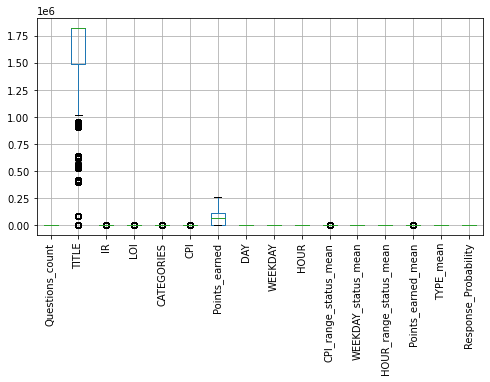

In [14]:
# 이상치 제거 전 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

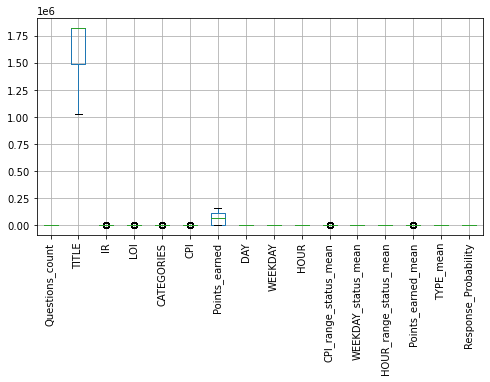

In [15]:
# 수치형 변수 이상치 제거
features[num] = features[num].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 이상치 제거 후 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

In [16]:
#StandardScaler
from sklearn.preprocessing import StandardScaler

# 스케일링 전 train, test 분할
X_train = features.iloc[:y_train.shape[0], :]
X_test = features.iloc[y_train.shape[0]:, :]

scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

In [17]:
# 원핫 인코딩
df_encoded = pd.get_dummies(pd.concat([X_train, X_test]), columns=cat)
X_train = df_encoded[:X_train.shape[0]]
X_test = df_encoded[X_train.shape[0]:]

# 5. 피쳐 셀렉션

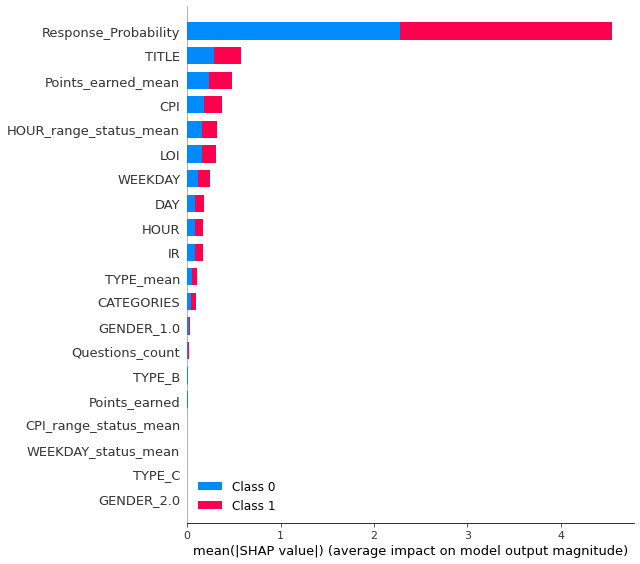

,column_name,shap_importance
15,Response_Probability,2.27688
1,TITLE,0.287013
13,Points_earned_mean,0.238454
5,CPI,0.183968
12,HOUR_range_status_mean,0.157187
3,LOI,0.1533
8,WEEKDAY,0.120584
7,DAY,0.0885408
9,HOUR,0.0855007
2,IR,0.0833419


In [18]:
# Method: Using SHAP values 
import shap
from lightgbm import LGBMClassifier

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [19]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
print(X_train.shape)

(1217508, 18)


# 6.딥러닝 모델링

In [20]:
# 매번 모델링을 할 때마다 동일한 결과를 얻기 위해 랜덤 시드 설정 동일하게 유지
# 럭키 시드 찾는건 시간상 어려움

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [22]:
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(128, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

DEEP = keras.Model(input, output)

DEEP.summary()

#Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

DEEP.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

hist = DEEP.fit(X_train, y_train, batch_size=1024, epochs=15, callbacks=[callbacks, mc], shuffle=False, verbose=2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_2 (Dense)             (None, 128)               2432      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1189/1189 - 2s - loss: 0.4142 - acc: 0.8099 - auc_1: 0.8899 - 2s/epoch - 2ms/step
Epoch 2/15
1189/1189 - 1s - loss: 0.3938 - acc: 0.8208 - auc_1: 0.9013 - 1s/epoch - 1ms/step
Epoch 3/15
1189/1189 - 1s - loss: 0.3890 - acc: 0.8232 - auc_1: 0.9038 - 1s/epoch - 1ms/step
Epoch 4/15
1189/1189 - 2s - loss: 0.3854 -

In [23]:
pd.DataFrame({'ID': test_id["ID"], 'STATUS': DEEP.predict(X_test).flatten()}).to_csv(os.path.abspath("./e_submission") + "/dnn.csv", index=False)